# Split dataset to test and train sets

In [1]:
import pandas as p,sklearn.model_selection as s
r='ratings.csv'
t=p.read_csv(r)
x,y=s.train_test_split(t,test_size=.1,stratify=t['userId'])
x.to_csv('train_'+r, index=False)
y.to_csv('test_'+r, index=False)

# Basic ideas and prep

### Necessary imports

In [5]:
import numpy as np
import pandas as pd
from sklearn.decomposition import NMF, TruncatedSVD
import os
from IPython.display import HTML
from IPython.display import clear_output
import matplotlib.pyplot as plt
from numba import jit, njit, vectorize
import time

### Pivoting dataframe into desired matrix

In [6]:
# read csv file
train = pd.read_csv('train_ratings.csv')
train = train.drop('timestamp', axis=1)

# change IDs to str because ints cannot be the dictionary keys
train['movieId'] = train['movieId'].transform(lambda x: 'movieId_' + str(x))
train['userId'] = train['userId'].transform(lambda x: 'userId_' + str(x))

# pivot long dataframe into matrix that we are interested in
Z = train.pivot(index='userId', columns='movieId', values='rating')
print(Z)

movieId     movieId_1  movieId_10  movieId_100  movieId_100083  \
userId                                                           
userId_1          NaN         NaN          NaN             NaN   
userId_10         NaN         NaN          NaN             NaN   
userId_100        NaN         NaN          NaN             NaN   
userId_101        NaN         NaN          NaN             NaN   
userId_102        NaN         NaN          NaN             NaN   
...               ...         ...          ...             ...   
userId_95         NaN         NaN          NaN             NaN   
userId_96         5.0         NaN          NaN             NaN   
userId_97         NaN         NaN          NaN             NaN   
userId_98         4.5         NaN          NaN             NaN   
userId_99         NaN         4.0          NaN             NaN   

movieId     movieId_100106  movieId_100159  movieId_100163  movieId_100194  \
userId                                                         

In [7]:
test = pd.read_csv('test_ratings.csv').drop('timestamp', axis=1)
test['movieId'] = test['movieId'].transform(lambda x: 'movieId_' + str(x))
test['userId'] = test['userId'].transform(lambda x: 'userId_' + str(x))
test = test.pivot(index='userId', columns='movieId', values='rating')
print(test)

movieId     movieId_1  movieId_10  movieId_100044  movieId_100068  \
userId                                                              
userId_1          4.0         NaN             NaN             NaN   
userId_10         NaN         NaN             NaN             NaN   
userId_100        NaN         NaN             NaN             NaN   
userId_101        NaN         NaN             NaN             NaN   
userId_102        NaN         NaN             NaN             NaN   
...               ...         ...             ...             ...   
userId_95         NaN         NaN             NaN             NaN   
userId_96         NaN         NaN             NaN             NaN   
userId_97         NaN         NaN             NaN             NaN   
userId_98         NaN         NaN             NaN             NaN   
userId_99         NaN         NaN             NaN             NaN   

movieId     movieId_100304  movieId_1004  movieId_100487  movieId_1005  \
userId                      

In [8]:
Z_full = pd.read_csv('ratings.csv').drop('timestamp', axis=1)
Z_full['movieId'] = Z_full['movieId'].transform(lambda x: 'movieId_' + str(x))
Z_full['userId'] = Z_full['userId'].transform(lambda x: 'userId_' + str(x))
Z_full = Z_full.pivot(index='userId', columns='movieId', values='rating')
print(Z_full)

movieId     movieId_1  movieId_10  movieId_100  movieId_100044  \
userId                                                           
userId_1          4.0         NaN          NaN             NaN   
userId_10         NaN         NaN          NaN             NaN   
userId_100        NaN         NaN          NaN             NaN   
userId_101        NaN         NaN          NaN             NaN   
userId_102        NaN         NaN          NaN             NaN   
...               ...         ...          ...             ...   
userId_95         NaN         NaN          NaN             NaN   
userId_96         5.0         NaN          NaN             NaN   
userId_97         NaN         NaN          NaN             NaN   
userId_98         4.5         NaN          NaN             NaN   
userId_99         NaN         4.0          NaN             NaN   

movieId     movieId_100068  movieId_100083  movieId_100106  movieId_100159  \
userId                                                         

In [9]:
@njit
def new_into_full(Z, Z_full, replace_column):
    full_matrix = np.zeros_like(Z_full)
    full_matrix[:] = np.nan

    i = 0
    for j in range(Z_full.shape[1]):
        if replace_column[j]:
            full_matrix[:, j] = Z[:, i]
            i += 1
    
    return full_matrix



# def transform_into_full_matrix(Z, Z_full):
#     # to calculate RMSE we need to transform Z into Z' that is matrix with shape
#     # equal to matrix formed with all of data, but with NaNs in places that are
#     # in test set
    
#     empty_column = [np.nan for _ in range(Z_full.shape[0])]
#     transformed_Z = Z_full.copy()
#     for column in Z_full.columns:
#         if column in Z.columns:
#             transformed_Z[column] = Z[column]
#         else:
#             transformed_Z[column] = empty_column
    
#     return transformed_Z

def transform_into_full_matrix(Z, Z_full):
    Z_columns = Z.columns.to_series().transform(lambda x: int(x[8:])).to_numpy()
    Z_full_columns = Z_full.columns.to_series().transform(lambda x: int(x[8:])).to_numpy()
    replace_column = np.isin(Z_full_columns, Z_columns)

    transformed_Z = new_into_full(Z.to_numpy(copy=True),
                                  Z_full.to_numpy(copy=True),
                                  replace_column,)
    
    transformed_Z = pd.DataFrame(data=transformed_Z,
                                 index=Z_full.index,
                                 columns=Z_full.columns,)
    
    return transformed_Z

In [10]:
%%time

Z_big = transform_into_full_matrix(Z, Z_full)
T_big = transform_into_full_matrix(test, Z_full)
print(Z_big)
print(T_big)

movieId     movieId_1  movieId_10  movieId_100  movieId_100044  \
userId                                                           
userId_1          NaN         NaN          NaN             NaN   
userId_10         NaN         NaN          NaN             NaN   
userId_100        NaN         NaN          NaN             NaN   
userId_101        NaN         NaN          NaN             NaN   
userId_102        NaN         NaN          NaN             NaN   
...               ...         ...          ...             ...   
userId_95         NaN         NaN          NaN             NaN   
userId_96         5.0         NaN          NaN             NaN   
userId_97         NaN         NaN          NaN             NaN   
userId_98         4.5         NaN          NaN             NaN   
userId_99         NaN         4.0          NaN             NaN   

movieId     movieId_100068  movieId_100083  movieId_100106  movieId_100159  \
userId                                                         

### Replacing NaN (basic ideas)

In [11]:
# values that are replacing NaNs in Z
# values is a dict which corresponds to 'columnname': value to replace
# so every NaN in a column is replaced by the same value, for now
values_movies = {movieId: Z.loc[:, movieId].mean() for movieId in Z.columns}
Z1 = Z.fillna(values_movies)

# if you want to replace NaN based on users' mean you have to transpose the matrix
# to get back to original dimensions of Z you have to transpose it back
# so in this case if user didn't rate a movie we assume that they
# would rate every movie similar
values_users = {userId: Z.T.loc[:, userId].mean() for userId in Z.T.columns}
Z2 = Z.T.fillna(values_users).T

Z3 = (0.9 * Z1 + 1.1 * Z2) / 2
print(Z1)
print(Z2)
print(Z3)

movieId     movieId_1  movieId_10  movieId_100  movieId_100083  \
userId                                                           
userId_1     3.927461    3.450413     2.785714             3.5   
userId_10    3.927461    3.450413     2.785714             3.5   
userId_100   3.927461    3.450413     2.785714             3.5   
userId_101   3.927461    3.450413     2.785714             3.5   
userId_102   3.927461    3.450413     2.785714             3.5   
...               ...         ...          ...             ...   
userId_95    3.927461    3.450413     2.785714             3.5   
userId_96    5.000000    3.450413     2.785714             3.5   
userId_97    3.927461    3.450413     2.785714             3.5   
userId_98    4.500000    3.450413     2.785714             3.5   
userId_99    3.927461    4.000000     2.785714             3.5   

movieId     movieId_100106  movieId_100159  movieId_100163  movieId_100194  \
userId                                                         

### RMSE function

In [12]:
def RMSE(Z_big, T_big):
    m = T_big.count().sum()
    diff_sq = Z_big.sub(T_big) ** 2
    s = diff_sq.sum().sum() / m

    return np.sqrt(s)

### Attempt to make kNN with covariance between users as a metric

In [ ]:
# Correlation matrix of users if there is no movies that connects users then correlation is NaN
# We are also interested in 'strength' of correlation so we take absolute value of it
%time corr_user_matrix = Z.T.corr(min_periods=1).abs()
# corr_user_matrix = corr_user_matrix.abs()
corr_user_matrix

CPU times: user 3.8 s, sys: 5.72 ms, total: 3.81 s
Wall time: 3.81 s


userId,userId_1,userId_10,userId_100,userId_101,userId_102,userId_103,userId_104,userId_105,userId_106,userId_107,userId_108,userId_109,userId_11,userId_110,userId_111,userId_112,userId_113,userId_114,userId_115,userId_116,userId_117,userId_118,userId_119,userId_12,userId_120,userId_121,userId_122,userId_123,userId_124,userId_125,userId_126,userId_127,userId_128,userId_129,userId_13,userId_130,userId_131,userId_132,userId_133,userId_134,...,userId_63,userId_64,userId_65,userId_66,userId_67,userId_68,userId_69,userId_7,userId_70,userId_71,userId_72,userId_73,userId_74,userId_75,userId_76,userId_77,userId_78,userId_79,userId_8,userId_80,userId_81,userId_82,userId_83,userId_84,userId_85,userId_86,userId_87,userId_88,userId_89,userId_9,userId_90,userId_91,userId_92,userId_93,userId_94,userId_95,userId_96,userId_97,userId_98,userId_99
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
userId_1,1.000000,0.086258,0.141019,0.343401,0.442326,0.092358,0.163586,0.103260,1.000000,0.230089,NaN,0.207819,0.000000,0.428571,0.169557,0.611341,0.555492,0.801784,0.250819,0.370088,0.040697,0.000000,0.178017,NaN,0.516515,0.043033,0.247688,0.131559,0.319127,0.232970,0.240048,NaN,0.247207,0.273349,0.878310,0.106066,0.000000,0.071579,0.425926,0.190221,...,0.172619,0.198384,0.577350,0.183669,0.288675,0.014930,0.043355,0.163824,0.091287,0.760886,0.635001,0.272166,0.097140,0.441437,0.294232,NaN,0.172380,0.135613,0.398596,0.265908,0.234206,0.201217,0.271403,0.082217,NaN,0.694915,NaN,0.866025,0.209057,0.904534,0.821584,0.101155,1.0,0.178174,0.319142,0.158469,0.017422,0.522233,0.489246,0.200000
userId_10,0.086258,1.000000,0.160111,0.396059,NaN,0.083130,0.077834,0.378040,0.529238,NaN,0.478947,0.639602,NaN,0.471405,0.068302,0.022228,0.348155,0.053483,0.566672,0.531369,0.500000,NaN,0.148389,0.500000,NaN,0.500000,0.300543,0.782210,0.508548,0.478605,NaN,NaN,NaN,0.296633,0.381246,1.000000,0.319843,0.326896,0.359211,1.000000,...,0.308410,0.045379,0.658036,0.216600,0.788275,0.086150,NaN,0.179767,0.321634,NaN,0.904534,0.223073,0.992835,0.871462,0.733453,0.016205,1.000000,1.000000,1.000000,0.017546,1.000000,0.011713,0.041603,0.000000,NaN,0.060674,NaN,0.872872,0.196940,NaN,NaN,0.294441,NaN,1.000000,0.866025,0.764471,1.000000,0.270501,0.206059,NaN
userId_100,0.141019,0.160111,1.000000,0.292770,0.448211,0.305762,0.117843,0.465230,NaN,0.841625,0.639010,0.276678,0.041345,NaN,0.120504,0.291246,0.256943,0.755929,0.032147,0.319215,0.344802,0.912871,0.250000,0.551014,NaN,0.566079,0.435628,NaN,0.320245,0.408248,0.500000,NaN,NaN,0.028904,0.000000,0.500000,0.904534,0.085732,0.000000,0.419314,...,0.238935,0.021941,1.000000,0.340344,NaN,0.241020,0.258199,0.293113,0.171499,0.100504,0.542326,0.214043,1.000000,NaN,0.125739,NaN,0.443533,0.080064,0.220905,0.665912,0.166667,0.045854,0.650000,0.093378,NaN,0.300000,NaN,0.500000,0.166347,0.944911,NaN,0.154298,NaN,0.774597,0.267114,0.317925,0.684936,0.968246,0.187317,0.193649
userId_101,0.343401,0.396059,0.292770,1.000000,NaN,0.369026,0.577350,0.584842,NaN,NaN,NaN,NaN,NaN,0.500000,0.661693,NaN,NaN,NaN,0.101091,0.970725,NaN,NaN,0.500000,NaN,NaN,NaN,0.320256,1.000000,0.944911,0.250000,NaN,NaN,NaN,0.539360,0.774597,NaN,1.000000,0.136312,NaN,NaN,...,0.585018,0.300947,NaN,0.067991,1.000000,0.081336,NaN,0.504219,NaN,NaN,0.327327,NaN,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN,1.000000,NaN,0.651584,NaN,NaN,NaN,1.000000,NaN,1.000000,0.072548,NaN,NaN,0.010988,NaN,NaN,NaN,0.307148,NaN,NaN,NaN,NaN
userId_102,0.442326,NaN,0.448211,NaN,1.000000,0.362209,0.567367,0.000000,NaN,0.046747,NaN,0.475948,0.460818,NaN,0.308094,0.053676,0.174078,NaN,0.493865,0.075498,0.359465,1.000000,0.323153,NaN,NaN,0.241505,0.397360,0.845154,0.804400,0.928477,0.212003,NaN,NaN,NaN,NaN,0.200000,0.400000,0.470595,0.376051,0.505814,...,0.536111,0.275568,NaN,0.608045,0.324443,0.170223,0.250000,0.256460,0.000000,0.577350,0.480384,NaN,NaN,0.216777,0.449028,NaN,0.124590,0.577350,0.144869,1.000000,0.289061,0.247861,0.325396,0.473879,NaN,0.490990,NaN,1.000

In [ ]:
def user_rating_weighted(userId, movieId, corr_matrix, Z):
    # ratings of corralated neighbors is weighted by the correlation coefficient
    # i.e. the more neighbor is correlated the more it brings to mean rating
    # input:    
    #           userId:         userId for whom we want to find neighbors
    #           movieId:        movieId for which we are finding most correlated users to userId
    #           corr_matrix:    correlation matrix of users
    #           Z:              main matrix of ratings
    # 
    # output:   predicted rating for given userId and movieId based on user's correlation to others

    neighbors = corr_matrix[userId]
    print(neighbors)
    neighbors = neighbors[~(Z[movieId].isna())]
    neighbors = neighbors[~(neighbors.index.isin([userId]))]
    neighbors = neighbors[~(neighbors.isna())]
    neighbors = neighbors[~(neighbors == 0)]
    rating = (Z.loc[neighbors.index, movieId] * neighbors).sum()/neighbors.sum()

    return rating, neighbors

In [ ]:
print(user_rating_weighted('userId_101', 'movieId_999', corr_user_matrix, Z))

userId
userId_1      0.343401
userId_10     0.396059
userId_100    0.292770
userId_101    1.000000
userId_102         NaN
                ...   
userId_95     0.307148
userId_96          NaN
userId_97          NaN
userId_98          NaN
userId_99          NaN
Name: userId_101, Length: 610, dtype: float64
(3.209741428886081, userId
userId_156    0.116968
userId_182    0.302250
userId_202    0.120386
userId_294    0.140685
userId_313    0.398527
userId_368    0.529150
userId_385    0.408248
userId_387    0.572263
userId_414    0.493033
Name: userId_101, dtype: float64)


It turned out that kNN is not the best way, because there is high variance of amount of users that rated given movie. So we look at all ratings of given movie and comute weighted mean with those ratings and bring correlation as weights.

### Attempt to make kNN with covariance between movies as a metric

In [ ]:
%time corr_movie_matrix = Z.corr(min_periods=1)
corr_movie_matrix = corr_movie_matrix.abs()
corr_movie_matrix

CPU times: user 36.5 s, sys: 232 ms, total: 36.7 s
Wall time: 36.6 s


movieId,movieId_1,movieId_10,movieId_100,movieId_100044,movieId_100068,movieId_100083,movieId_100106,movieId_100159,movieId_100163,movieId_100194,movieId_100226,movieId_100277,movieId_1003,movieId_100302,movieId_100304,movieId_100306,movieId_100326,movieId_100383,movieId_100390,movieId_100397,movieId_1004,movieId_100487,movieId_100498,movieId_1005,movieId_100507,movieId_100527,movieId_100553,movieId_100556,movieId_100579,movieId_1006,movieId_100611,movieId_1007,movieId_100714,movieId_1008,movieId_100810,movieId_100843,movieId_100882,movieId_1009,movieId_100906,movieId_101,...,movieId_98799,movieId_988,movieId_98809,movieId_98836,movieId_98908,movieId_98961,movieId_99,movieId_990,movieId_99005,movieId_99007,movieId_99087,movieId_991,movieId_99106,movieId_99112,movieId_99114,movieId_99117,movieId_99122,movieId_99130,movieId_99145,movieId_99149,movieId_99191,movieId_993,movieId_994,movieId_99437,movieId_99532,movieId_99574,movieId_996,movieId_99636,movieId_99638,movieId_99728,movieId_99750,movieId_99764,movieId_998,movieId_99813,movieId_99846,movieId_99853,movieId_999,movieId_99910,movieId_99917,movieId_99992
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
movieId_1,1.000000,0.005869,0.866025,NaN,NaN,NaN,NaN,NaN,0.692046,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.188982,0.355036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.059701,NaN,NaN,NaN,NaN,NaN,0.158777,NaN,0.271278,...,NaN,NaN,0.236792,NaN,NaN,0.166667,NaN,NaN,NaN,0.020690,NaN,0.752384,1.0,0.12500,0.341451,0.057639,NaN,NaN,NaN,1.0,NaN,NaN,0.463281,NaN,NaN,NaN,0.500000,NaN,NaN,0.785714,NaN,1.0,1.0,0.986928,NaN,NaN,0.807573,NaN,1.0,NaN
movieId_10,0.005869,1.000000,0.581318,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.556187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.060193,NaN,NaN,NaN,NaN,NaN,0.333333,NaN,0.158673,...,NaN,NaN,0.135365,NaN,NaN,0.447214,NaN,NaN,NaN,0.327327,NaN,0.557086,NaN,0.40625,0.293154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.402077,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.815693,NaN,NaN,NaN
movieId_100,0.866025,0.581318,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.866025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
movieId_100044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
movieId_100068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
movieId_99853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
movieId_999,0.807573,0.815693,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Na

In [ ]:
def movie_rating_weighted(userId, movieId, corr_matrix, Z):
    # based on idea of kNN for movie correlation, but for this time we take as large k as possible
    # because there is high variance for amount of ratings given to movies
    # i.e some movie have just 1 rating and others >50
    # so choosing k is not a trivial task
    # that's why we decide to take all movies rated by given user
    # and compute weighted mean on those ratings
    # input:    
    #           userId:         userId for whom we want to prediction
    #           movieId:        movieId for which we are finding most correlated other movies
    #           corr_matrix:    correlation matrix of movies
    #           Z:              main matrix of ratings
    # 
    # output:   predicted rating for given userId and movieId based on movie's correlation to others

    neighbors = corr_matrix[movieId]
    neighbors = neighbors[~(Z.T[userId].isna())]
    neighbors = neighbors[~(neighbors.index.isin([movieId]))]
    neighbors = neighbors[~(neighbors.isna())]

    rating = (Z.T.loc[neighbors.index, userId] * neighbors).sum()/neighbors.sum()

    return rating, neighbors

In [ ]:
print(user_rating_weighted('userId_101', 'movieId_999', corr_user_matrix, Z))
print(movie_rating_weighted('userId_101', 'movieId_999', corr_movie_matrix, Z))

(3.225411490533645, userId
userId_156    0.270868
userId_202    0.269191
userId_294    0.222222
userId_313    0.461906
userId_368    0.687408
userId_385    0.166667
userId_387    0.375800
userId_414    0.558428
userId_599    0.446706
Name: userId_101, dtype: float64)
(3.8701310791926375, movieId
movieId_1127    0.578315
movieId_1210    0.589768
movieId_1719    0.500000
movieId_223     0.132453
movieId_2395    0.197642
movieId_2396    0.108465
movieId_2599    0.333333
movieId_2692    0.522233
movieId_2700    0.000000
movieId_2716    0.573462
movieId_2723    0.500000
movieId_2858    0.366463
movieId_2997    0.166667
movieId_3081    0.188982
movieId_3160    0.500000
movieId_3175    0.801784
movieId_3578    0.722222
movieId_370     0.171499
movieId_3793    0.866025
movieId_785     1.000000
Name: movieId_999, dtype: float64)


## Combining weighted movie and user rating

In [ ]:
def combine(userId, movieId, corr_user, corr_movie, Z):
    # combined approach of kNN for users and weighted mean 
    # input:    
    #           userId:         userId for whom we want to prediction
    #           movieId:        movieId for which we are finding most correlated other movies
    #           corr_user:      correlation matrix of users
    #           corr_movie:     correlation matrix of movies
    #           Z:              main matrix of ratings
    user_neighbors = user_rating_weighted(userId, movieId, corr_user, Z)[1]
    movie_neighbors = movie_rating_weighted(userId, movieId, corr_movie, Z)[1]

    rating_movies = (Z.T.loc[movie_neighbors.index, userId] * movie_neighbors).sum()
    rating_users = (Z.loc[user_neighbors.index, movieId] * user_neighbors).sum()

    combined_rating = (rating_movies + rating_users)/(user_neighbors.sum() + movie_neighbors.sum())

    return combined_rating


In [ ]:
def compare_methods(userId, movieId, corr_user_matrix, corr_movie_matrix, Z):
    comb = combine(userId, movieId, corr_user_matrix, corr_movie_matrix, Z)
    user_r = user_rating_weighted(userId, movieId, corr_user_matrix, Z)
    movie_r = movie_rating_weighted(userId, movieId, corr_movie_matrix, Z)
    print(f'Initiall prediction of movie ratings for: {userId} and {movieId}')
    print(f'Combined approach:\t\t {comb}')
    print(f'User focused approach:\t\t {user_r[0]}')
    print(f'Movie focused approach:\t\t {movie_r[0]}')
    print('')


compare_methods('userId_101', 'movieId_1', corr_user_matrix, corr_movie_matrix, Z)
compare_methods('userId_101', 'movieId_10', corr_user_matrix, corr_movie_matrix, Z)
compare_methods('userId_101', 'movieId_100', corr_user_matrix, corr_movie_matrix, Z)
compare_methods('userId_1', 'movieId_1', corr_user_matrix, corr_movie_matrix, Z)
compare_methods('userId_1', 'movieId_10', corr_user_matrix, corr_movie_matrix, Z)
compare_methods('userId_1', 'movieId_100', corr_user_matrix, corr_movie_matrix, Z)

Initiall prediction of movie ratings for: userId_101 and movieId_1
Combined approach:		 3.724971033603245
User focused approach:		 3.787152751475664
Movie focused approach:		 3.5049150147540398

Initiall prediction of movie ratings for: userId_101 and movieId_10
Combined approach:		 3.482597912720797
User focused approach:		 3.3596106421855243
Movie focused approach:		 3.680187402508128

Initiall prediction of movie ratings for: userId_101 and movieId_100
Combined approach:		 3.63833605576329
User focused approach:		 2.717686694401214
Movie focused approach:		 3.7690859603105604

Initiall prediction of movie ratings for: userId_1 and movieId_1
Combined approach:		 4.114911477144624
User focused approach:		 3.9284656568520666
Movie focused approach:		 4.329251073230387

Initiall prediction of movie ratings for: userId_1 and movieId_10
Combined approach:		 4.010586324475937
User focused approach:		 3.507298454743974
Movie focused approach:		 4.257059740233323

Initiall prediction of movi

# Trying to use numba to speed up some computation

In [ ]:
# If there will be some spare time, we can try to do it
# but that's not neccecery

# Implementation of ALG

### SVD1 function

In [ ]:
def SVD1(Z_svd, Z_full, T_big):
    svd = TruncatedSVD(n_components=Z_full.shape[0] // 60, random_state=2137)
    svd.fit(Z_svd)
    Sigma2 = np.diag(svd.singular_values_)
    VT = svd.components_
    W = svd.transform(Z_svd)/svd.singular_values_
    H = np.dot(Sigma2, VT)
    approx_Z = np.dot(W, H)
    Z_svd = pd.DataFrame(data=approx_Z, index=Z_svd.index, columns=Z_svd.columns)
    # Z_svd = np.around(Z_svd * 2) / 2
    # print(Z_svd)

    return RMSE(transform_into_full_matrix(Z_svd, Z_full), T_big)

In [ ]:
%time print(SVD1(Z.fillna(0), Z_full, T_big))
%time print(SVD1(Z1, Z_full, T_big))
%time print(SVD1(Z2, Z_full, T_big))
%time print(SVD1(Z3, Z_full, T_big))
%time print(SVD1(Z.fillna(Z.mean().mean()), Z_full, T_big))

2.790896463584593
CPU times: user 3.04 s, sys: 844 ms, total: 3.88 s
Wall time: 3 s
0.9080607456468291
CPU times: user 2.99 s, sys: 711 ms, total: 3.7 s
Wall time: 2.86 s
0.875687910230594
CPU times: user 2.9 s, sys: 668 ms, total: 3.57 s
Wall time: 2.74 s
0.8436349958617096
CPU times: user 2.88 s, sys: 595 ms, total: 3.48 s
Wall time: 2.71 s
0.9558550857674625
CPU times: user 3.11 s, sys: 714 ms, total: 3.83 s
Wall time: 3 s


### NMF function

In [ ]:
def my_NMF(Z_nmf, Z_full, T_big):
    nmf = NMF(n_components=Z_full.shape[0] // 60, init='random', random_state=2137)
    W = nmf.fit_transform(Z_nmf)
    H = nmf.components_
    approx_Z = np.dot(W, H)
    Z_nmf = pd.DataFrame(data=approx_Z, index=Z_nmf.index, columns=Z_nmf.columns)

    return RMSE(transform_into_full_matrix(Z_nmf, Z_full), T_big)

In [ ]:
%time print(my_NMF(Z.fillna(0), Z_full, T_big))
%time print(my_NMF(Z1, Z_full, T_big))
%time print(my_NMF(Z2, Z_full, T_big))
%time print(my_NMF(Z3, Z_full, T_big))
%time print(my_NMF(Z.fillna(Z.mean().mean()), Z_full, T_big))

2.8363438040963156
CPU times: user 13.9 s, sys: 1.05 s, total: 15 s
Wall time: 8.8 s
0.9152984651064218
CPU times: user 18.7 s, sys: 996 ms, total: 19.7 s
Wall time: 11 s
0.8762137653334399
CPU times: user 19.6 s, sys: 1.03 s, total: 20.6 s
Wall time: 11.5 s
0.8547191811824838
CPU times: user 18.8 s, sys: 1.09 s, total: 19.9 s
Wall time: 11.1 s
0.9645316290204635
CPU times: user 18.8 s, sys: 1.06 s, total: 19.9 s
Wall time: 11.1 s


### SVD2 function

In [ ]:
def are_different(X, Y, eps=1e-5):
    diff = X - Y
    diff = np.linalg.norm(diff)
    return diff > eps


def SVD2_all(Z_current, Z_full, T_big, Z=Z, eps=1e-5):
    rmses = []
    i = 1

    svd = TruncatedSVD(n_components=Z_full.shape[0] // 60, random_state=2137)

    Z_previous = Z_current.copy()
    svd.fit(Z_current)
    Sigma2 = np.diag(svd.singular_values_)
    VT = svd.components_
    W = svd.transform(Z_current)/svd.singular_values_
    H = np.dot(Sigma2, VT)
    approx_Z = np.dot(W, H)
    Z_current = pd.DataFrame(data=approx_Z, index=Z_current.index, columns=Z_current.columns)
    Z_current = Z_current * Z.isna() + Z.fillna(0)
    rmses.append(RMSE(transform_into_full_matrix(Z_current, Z_full), T_big))

    while are_different(Z_previous, Z_current, eps):
        print(f'Current iteration: {i}')
        print(f'Current RMSE: {rmses[-1]}')
        i += 1

        Z_previous = Z_current.copy()
        svd.fit(Z_current)
        Sigma2 = np.diag(svd.singular_values_)
        VT = svd.components_
        W = svd.transform(Z_current)/svd.singular_values_
        H = np.dot(Sigma2, VT)
        approx_Z = np.dot(W, H)
        Z_current = pd.DataFrame(data=approx_Z, index=Z_current.index, columns=Z_current.columns)
        Z_current = Z_current * Z.isna() + Z.fillna(0)
        rmses.append(RMSE(transform_into_full_matrix(Z_current, Z_full), T_big))

        clear_output()

    return rmses

def SVD2(Z_current, Z_full, T_big, Z=Z, eps=1e-5):
    return SVD2(Z_current, Z_full, T_big, Z=Z, eps=1e-5)[-1]

CPU times: user 4min 37s, sys: 1min 2s, total: 5min 40s
Wall time: 4min 20s


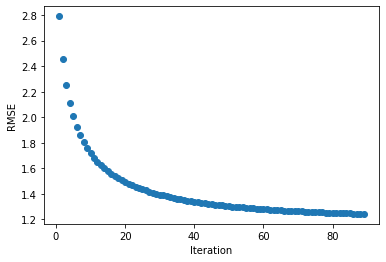

In [ ]:
%%time

res_zeros = SVD2_all(Z.fillna(0), Z_full, T_big, eps=10)
plt.scatter(np.arange(1, len(res_zeros)+1), res_zeros)
plt.xlabel('Iteration')
plt.ylabel('RMSE')

CPU times: user 1min 33s, sys: 21.3 s, total: 1min 54s
Wall time: 1min 27s


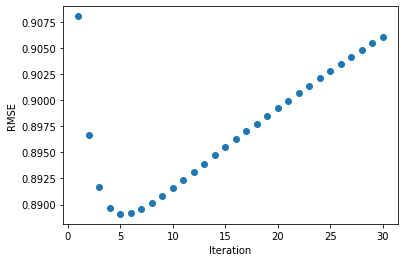

In [ ]:
%%time

res_movies = SVD2_all(Z1, Z_full, T_big, eps=10)
plt.scatter(np.arange(1, len(res_movies)+1), res_movies)
plt.xlabel('Iteration')
plt.ylabel('RMSE')

CPU times: user 1min 46s, sys: 24.4 s, total: 2min 10s
Wall time: 1min 39s


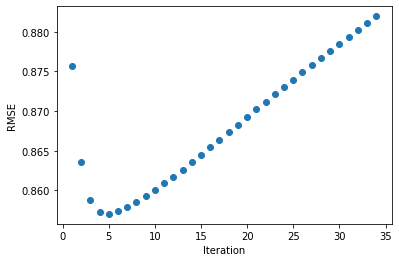

In [ ]:
%%time

res_users = SVD2_all(Z2, Z_full, T_big, eps=10)
plt.scatter(np.arange(1, len(res_users)+1), res_users)
plt.xlabel('Iteration')
plt.ylabel('RMSE')

CPU times: user 1min 33s, sys: 21.1 s, total: 1min 54s
Wall time: 1min 27s


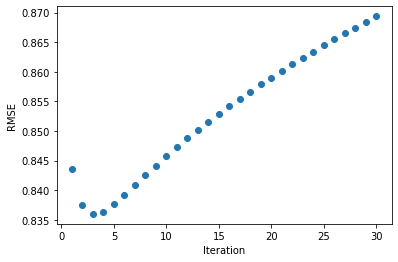

In [ ]:
%%time

res_weighted = SVD2_all(Z3, Z_full, T_big, eps=10)
plt.scatter(np.arange(1, len(res_weighted)+1), res_weighted)
plt.xlabel('Iteration')
plt.ylabel('RMSE')

CPU times: user 1min 55s, sys: 26.2 s, total: 2min 22s
Wall time: 1min 48s


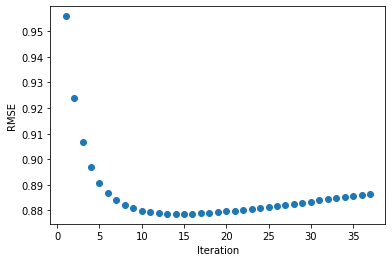

In [ ]:
%%time

res_mean = SVD2_all(Z.fillna(Z.mean().mean()), Z_full, T_big, eps=10)
plt.scatter(np.arange(1, len(res_mean)+1), res_mean)
plt.xlabel('Iteration')
plt.ylabel('RMSE')

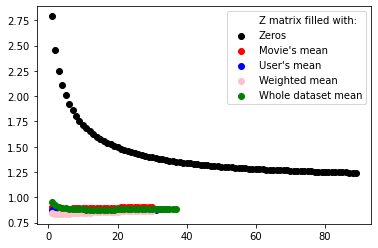

In [ ]:
plt.plot([], [], ' ', label='Z matrix filled with:')
plt.scatter(np.arange(1, len(res_zeros)+1), res_zeros, c='black', label='Zeros')
plt.scatter(np.arange(1, len(res_movies)+1), res_movies, c='red', label='Movie\'s mean')
plt.scatter(np.arange(1, len(res_users)+1), res_users, c='blue', label='User\'s mean')
plt.scatter(np.arange(1, len(res_weighted)+1), res_weighted, c='pink', label='Weighted mean')
plt.scatter(np.arange(1, len(res_mean)+1), res_mean, c='green', label='Whole dataset mean')
plt.legend(loc='upper right')

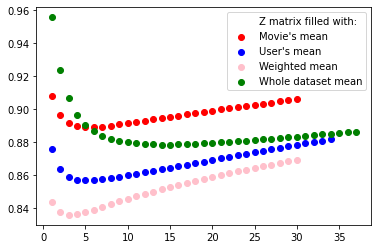

In [ ]:
plt.plot([], [], ' ', label='Z matrix filled with:')
plt.scatter(np.arange(1, len(res_movies)+1), res_movies, c='red', label='Movie\'s mean')
plt.scatter(np.arange(1, len(res_users)+1), res_users, c='blue', label='User\'s mean')
plt.scatter(np.arange(1, len(res_weighted)+1), res_weighted, c='pink', label='Weighted mean')
plt.scatter(np.arange(1, len(res_mean)+1), res_mean, c='green', label='Whole dataset mean')
plt.legend(loc='upper right')

In [ ]:
# zeros
print(res_zeros[-1])

# movies
print(res_movies[-1])

# users
print(res_users[-1])

# weighted
print(res_weighted[-1])

# mean
print(res_mean[-1])


1.243525306002386
0.9061057797868166
0.8819617572164274
0.8693734174869256
0.8865258608130722


### Tuned SVD2, so that if RMSE starts to increase, loop is ended

In [ ]:
def SVD2_all_tuned(Z_current, Z_full, T_big, Z=Z, eps=1e-5):
    rmses = [100000]
    i = 1

    svd = TruncatedSVD(n_components=Z_full.shape[0] // 60, random_state=2137)

    Z_previous = Z_current.copy()
    svd.fit(Z_current)
    Sigma2 = np.diag(svd.singular_values_)
    VT = svd.components_
    W = svd.transform(Z_current)/svd.singular_values_
    H = np.dot(Sigma2, VT)
    approx_Z = np.dot(W, H)
    Z_current = pd.DataFrame(data=approx_Z, index=Z_current.index, columns=Z_current.columns)
    Z_current = Z_current * Z.isna() + Z.fillna(0)
    rmses.append(RMSE(transform_into_full_matrix(Z_current, Z_full), T_big))

    while are_different(Z_previous, Z_current, eps) and rmses[-1] < rmses[-2]:
        print(f'Current iteration: {i}')
        print(f'Current RMSE: {rmses[-1]}')
        i += 1

        Z_previous = Z_current.copy()
        svd.fit(Z_current)
        Sigma2 = np.diag(svd.singular_values_)
        VT = svd.components_
        W = svd.transform(Z_current)/svd.singular_values_
        H = np.dot(Sigma2, VT)
        approx_Z = np.dot(W, H)
        Z_current = pd.DataFrame(data=approx_Z, index=Z_current.index, columns=Z_current.columns)
        Z_current = Z_current * Z.isna() + Z.fillna(0)
        rmses.append(RMSE(transform_into_full_matrix(Z_current, Z_full), T_big))

        clear_output()

    return rmses[1:-1]

def SVD2_tuned(Z_current, Z_full, T_big, Z=Z, eps=1e-5):
    return SVD2_all_tuned(Z_current, Z_full, T_big, Z=Z, eps=eps)[-1]

CPU times: user 4min 37s, sys: 1min 2s, total: 5min 40s
Wall time: 4min 19s


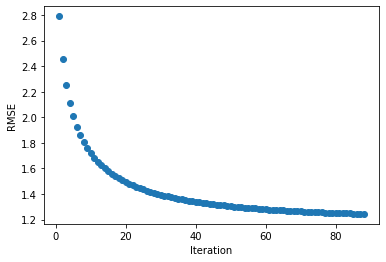

In [ ]:
%%time

res_zeros_tuned = SVD2_all_tuned(Z.fillna(0), Z_full, T_big, eps=10)
plt.scatter(np.arange(1, len(res_zeros_tuned)+1), res_zeros_tuned)
plt.xlabel('Iteration')
plt.ylabel('RMSE')

CPU times: user 18.4 s, sys: 4.21 s, total: 22.6 s
Wall time: 17.3 s


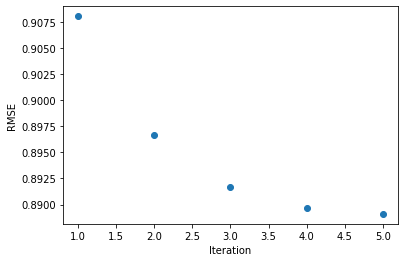

In [ ]:
%%time

res_movies_tuned = SVD2_all_tuned(Z1, Z_full, T_big, eps=10)
plt.scatter(np.arange(1, len(res_movies_tuned)+1), res_movies_tuned)
plt.xlabel('Iteration')
plt.ylabel('RMSE')

CPU times: user 19.1 s, sys: 4.15 s, total: 23.3 s
Wall time: 17.8 s


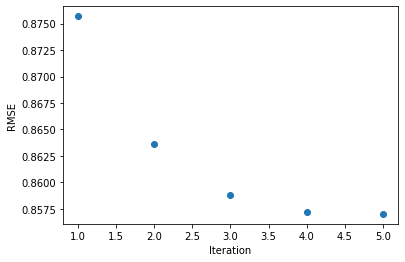

In [ ]:
%%time

res_users_tuned = SVD2_all_tuned(Z2, Z_full, T_big, eps=10)
plt.scatter(np.arange(1, len(res_users_tuned)+1), res_users_tuned)
plt.xlabel('Iteration')
plt.ylabel('RMSE')

CPU times: user 12.4 s, sys: 2.84 s, total: 15.3 s
Wall time: 11.7 s


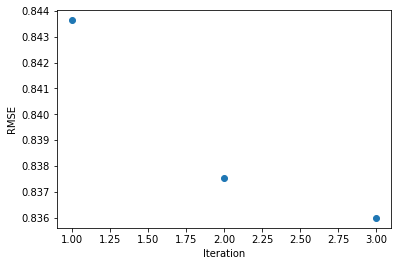

In [ ]:
%%time

res_weighted_tuned = SVD2_all_tuned(Z3, Z_full, T_big, eps=10)
plt.scatter(np.arange(1, len(res_weighted_tuned)+1), res_weighted_tuned)
plt.xlabel('Iteration')
plt.ylabel('RMSE')

CPU times: user 47.3 s, sys: 10.6 s, total: 57.9 s
Wall time: 44.3 s


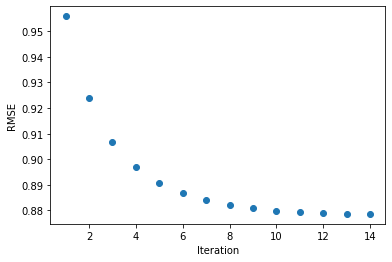

In [ ]:
%%time

res_mean_tuned = SVD2_all_tuned(Z.fillna(Z.mean().mean()), Z_full, T_big, eps=10)
plt.scatter(np.arange(1, len(res_mean_tuned)+1), res_mean_tuned)
plt.xlabel('Iteration')
plt.ylabel('RMSE')

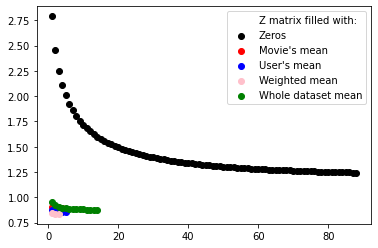

In [ ]:
plt.plot([], [], ' ', label='Z matrix filled with:')
plt.scatter(np.arange(1, len(res_zeros_tuned)+1), res_zeros_tuned, c='black', label='Zeros')
plt.scatter(np.arange(1, len(res_movies_tuned)+1), res_movies_tuned, c='red', label='Movie\'s mean')
plt.scatter(np.arange(1, len(res_users_tuned)+1), res_users_tuned, c='blue', label='User\'s mean')
plt.scatter(np.arange(1, len(res_weighted_tuned)+1), res_weighted_tuned, c='pink', label='Weighted mean')
plt.scatter(np.arange(1, len(res_mean_tuned)+1), res_mean_tuned, c='green', label='Whole dataset mean')
plt.legend(loc='upper right')

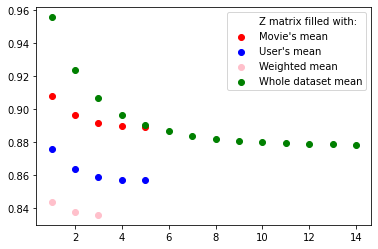

In [ ]:
plt.plot([], [], ' ', label='Z matrix filled with:')
plt.scatter(np.arange(1, len(res_movies_tuned)+1), res_movies_tuned, c='red', label='Movie\'s mean')
plt.scatter(np.arange(1, len(res_users_tuned)+1), res_users_tuned, c='blue', label='User\'s mean')
plt.scatter(np.arange(1, len(res_weighted_tuned)+1), res_weighted_tuned, c='pink', label='Weighted mean')
plt.scatter(np.arange(1, len(res_mean_tuned)+1), res_mean_tuned, c='green', label='Whole dataset mean')
plt.legend(loc='upper right')

In [ ]:
# zeros
print(res_zeros_tuned[-1])

# movies
print(res_movies_tuned[-1])

# users
print(res_users_tuned[-1])

# weighted
print(res_weighted_tuned[-1])

# mean
print(res_mean_tuned[-1])


1.244358482566069
0.889100051689252
0.8570315538562356
0.8359883013528286
0.8786617480152549


# Attempt to find best pair of biases for any ALG

### Testing if different bias has impact on RMSE

In [ ]:
from tqdm.notebook import tqdm


min_RMSE = 10000
min_movie_bias = 0
min_user_bias = 0
for movie_bias in tqdm(np.arange(-0.1, 0.11, 0.02)):
    for user_bias in tqdm(np.arange(-0.1, 0.11, 0.02), leave=False):
        print(f'With movie bias: {movie_bias} and user bias: {user_bias}')
        if movie_bias == user_bias:
            print('Skipped, biases are equal!')
            print('')
            continue
        
        Z_merged = (Z1 * (1 + movie_bias) + Z2 * (1 + user_bias)) / (2 + movie_bias + user_bias)
        current_RMSE = SVD1(Z_merged, Z_full, T_big)
        print(f'RMSE of SVD1 prediction is {current_RMSE}')
        print('')
        if current_RMSE < min_RMSE:
            min_RMSE = current_RMSE
            min_movie_bias = movie_bias
            min_user_bias = user_bias

print(f'Min RMSE is achived with movie bias: {min_movie_bias} and user bias: {min_user_bias}')
print(f'And is equal to {min_RMSE}')

NameError: ignored

In [ ]:
min_RMSE = 10000
min_movie_bias = 0
min_user_bias = 0
movie_bias = 0
for user_bias in tqdm(np.arange(0.15, 0.25, 0.01), leave=False):
    print(f'With movie bias: {movie_bias} and user bias: {user_bias}')
    if movie_bias == user_bias:
        print('Skipped, biases are equal!')
        print('')
        continue
    
    Z_merged = (Z1 * (1 + movie_bias) + Z2 * (1 + user_bias)) / (2 + movie_bias + user_bias)
    current_RMSE = SVD1(Z_merged, Z_full, T_big)
    print(f'RMSE of SVD1 prediction is {current_RMSE}')
    print('')
    if current_RMSE < min_RMSE:
        min_RMSE = current_RMSE
        min_movie_bias = movie_bias
        min_user_bias = user_bias

print(f'Min RMSE is achived with movie bias: {min_movie_bias} and user bias: {min_user_bias}')
print(f'And is equal to {min_RMSE}')

With movie bias: 0 and user bias: 0.15
RMSE of SVD1 prediction is 0.871053390907944

With movie bias: 0 and user bias: 0.16
RMSE of SVD1 prediction is 0.8710411441242747

With movie bias: 0 and user bias: 0.17
RMSE of SVD1 prediction is 0.8710312461930824

With movie bias: 0 and user bias: 0.18000000000000002
RMSE of SVD1 prediction is 0.8710236342364236

With movie bias: 0 and user bias: 0.19000000000000003
RMSE of SVD1 prediction is 0.8710182470626715

With movie bias: 0 and user bias: 0.20000000000000004
RMSE of SVD1 prediction is 0.871015025116805

With movie bias: 0 and user bias: 0.21000000000000005
RMSE of SVD1 prediction is 0.8710139104322807

With movie bias: 0 and user bias: 0.22000000000000006
RMSE of SVD1 prediction is 0.8710148465845148

With movie bias: 0 and user bias: 0.23000000000000007
RMSE of SVD1 prediction is 0.871017778645854

With movie bias: 0 and user bias: 0.24000000000000007
RMSE of SVD1 prediction is 0.871022653142018

Min RMSE is achived with movie bias: 0 

### Function that finds best bias!

In [ ]:
from IPython.display import clear_output


def find_min_RMSE(Z1, Z2, Z_full, T_big, alg=SVD1):
    min_RMSE = 10000
    min_movie_bias = 0
    min_user_bias = 0
    movie_bias = 0.0
    user_bias = 0.15
    previous_RMSE = 10000
    iteration = 1
    
    print(f'Looking for min RMSE...')
    
    Z_merged = (Z1 * (1 + movie_bias) + Z2 * (1 + user_bias)) / (2 + movie_bias + user_bias)
    current_RMSE = alg(Z_merged, Z_full, T_big)

    while current_RMSE < previous_RMSE and iteration < 21:
        #os.system('cls')
        clear_output()
        print(f'Looking for min RMSE...')
        print(f'Current RMSE: {current_RMSE}')
        print(f'Iterations: {iteration}')
        if current_RMSE < min_RMSE:
            min_RMSE = current_RMSE
            min_movie_bias = movie_bias
            min_user_bias = user_bias
        
        user_bias += 0.02
        iteration += 1
        previous_RMSE = current_RMSE
        Z_merged = (Z1 * (1 + movie_bias) + Z2 * (1 + user_bias)) / (2 + movie_bias + user_bias)
        current_RMSE = alg(Z_merged, Z_full, T_big)
    
    #os.system('cls')
    clear_output()
    print(f'Min RMSE found is equal to {min_RMSE}')
    print(f'Iterations: {iteration - 1}')

    return min_RMSE

In [ ]:
%time find_min_RMSE(Z1, Z2, Z_full, T_big)

Min RMSE found is equal to 0.8748903036279494
Iterations: 1
CPU times: user 24.4 s, sys: 5.9 s, total: 30.3 s
Wall time: 17.4 s


0.8748903036279494

In [ ]:
%time find_min_RMSE(Z1, Z2, Z_full, T_big, alg=my_NMF)

Min RMSE found is equal to 0.8573599886089757
Iterations: 20
CPU times: user 16min 31s, sys: 7min 38s, total: 24min 9s
Wall time: 13min 12s


0.8573599886089757

# SGD implementation

![picture](https://i.ibb.co/XbxRTtD/SGDgradient-1.png)

## Some additional functions

In [14]:
def SGD_loss_slow(Z, W, H, l=0.0):
    Z_mask = ~np.isnan(Z)
    loss = 0
    penalty = 0
    
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            if Z_mask[i, j]:
                w = W[i,:]
                h = H[:,j].reshape(-1, 1)
                loss = loss + (Z[i, j] - np.matmul(w, h)) ** 2
                penalty = penalty + l * ((w ** 2).sum() + (h ** 2).sum())
    
    return loss[0] + penalty

@njit
def SGD_loss(Z, Z_filled, W, H, l=0.0):
    Z_mask = ~np.isnan(Z)
    W = W.astype(np.float32)
    H = H.astype(np.float32)

    Z_non_empty_columns = Z_mask.sum(axis=0)
    Z_non_empty_rows = Z_mask.sum(axis=1)

    loss = ((Z_filled - (W @ H) * Z_mask) ** 2).sum()
    H_sums = (H ** 2).sum(axis=0)
    W_sums = (W ** 2).sum(axis=1)
    
    penalty = l * ((H_sums * Z_non_empty_columns).sum() + (W_sums * Z_non_empty_rows).sum())
    
    return loss + penalty

@njit
def SGD_loss_and_gradient(Z, W, H, i, j, l=0.0):
    # we will use this calculation few times, so to reduce time, we 
    # will store it in a variable
    diff = (Z[i, j] - np.dot(W[i, :], H[:, j]))

    # the gradients of Wi and Hj vecotrs
    W_grad = -2 * diff * H[:, j] + 2 * l * W[i, :]
    H_grad = -2 * diff * W[i, :] + 2 * l * H[:, j]

    # the loss for our problem
    loss = diff ** 2

    return W_grad, H_grad, loss

## The function to perform SGD

In [15]:
@njit
def SGD(Z, W, H,
        alpha=1e-2,
        alpha_decay = 1,
        multiply_alpha_after_epochs = 10,
        momentum = 0,
        decay = 0,
        l=0.0,
        num_epoch=1000):
    ## prep for performing SGD
    Z_mask = Z != 0
    coords = np.where(Z_mask)

    # this is list of pairs that are non empty in Z
    coords = np.array([(coords[0][i], coords[1][i]) for i in range(len(coords[0]))])

    # in order to use numba we have to convert everything to proper types
    W = W.astype(np.float32)
    H = H.astype(np.float32)

    # adding velocity parameter to the model
    W_velocity = np.zeros_like(W)
    H_velocity = np.zeros_like(H)

    # list of all losses achived during trainging
    losses = np.zeros(num_epoch)
    for epoch in range(num_epoch):
        # shuffling coords, core step in SGD
        np.random.shuffle(coords)

        # reseting loss for each epoch
        loss = 0

        for iter_ in range(coords.shape[0]):
            i = coords[iter_][0]
            j = coords[iter_][1]

            W_grad, H_grad, current_loss = SGD_loss_and_gradient(Z, W , H, i, j, l=l)

            # Implementation of weight decay on weights, by changing the gradients
            W_grad += decay * W[i, :]
            H_grad += decay * H[:, j]

            # Updating velocity of search with momentum
            W_velocity[i, :] = W_velocity[i, :] * momentum + alpha * W_grad
            H_velocity[:, j] = H_velocity[:, j] * momentum + alpha * H_grad

            # going with matrices along gradient with given learning rate = alpha
            W[i, :] = W[i, :] - W_velocity[i, :]
            H[:, j] = H[:, j] - H_velocity[:, j]
            
            # update of loss function for given coords, standarized
            loss = loss + current_loss / coords.shape[0]
    
        # applying alpha decay
        # the longer we search, the shorter is the learning rate
        if epoch % multiply_alpha_after_epochs == 0:
            alpha = alpha * alpha_decay
        losses[epoch] = loss
    
    return W, H, losses

###Some initial testing

In [17]:
# precompile of gradient
a1 = np.array([[1, np.nan, 3],
               [0, 1, 1],
               [2, 2, 3]])
a2 = np.array([[1, 0],
               [0, 1],
               [2, 3]])
a3 = np.array([[2, 2, 3],
               [1, 0, 1]])

%time w, h, losses  = SGD(np.nan_to_num(a1), a2, a3)
w @ h, losses[-1]

CPU times: user 7.38 ms, sys: 0 ns, total: 7.38 ms
Wall time: 7.35 ms


(array([[0.99893993, 1.9677985 , 3.0008252 ],
        [0.8045428 , 0.8008094 , 1.1289891 ],
        [1.9999437 , 2.0805197 , 2.9540532 ]], dtype=float32),
 0.010713696923224755)

In [19]:
r = Z.shape[0] // 60
m1 = Z.to_numpy(copy=True)
m1_filled = np.nan_to_num(m1)
m2 = np.random.normal(size=(Z.shape[0], r))
m3 = np.random.normal(size=(r, Z.shape[1]))

%time w, h, losses = SGD(m1_filled, m2, m3, alpha=0.005, alpha_decay=1, l=0.1, num_epoch=100)
predicted_Z = w @ h

predicted_Z = pd.DataFrame(data = predicted_Z,
                           index = Z.index,
                           columns = Z.columns)
%time predicted_Z_big = transform_into_full_matrix(predicted_Z, Z_full)
RMSE(predicted_Z_big, T_big), losses[-1]

CPU times: user 10.4 s, sys: 55.1 ms, total: 10.5 s
Wall time: 10.5 s
CPU times: user 182 ms, sys: 109 ms, total: 291 ms
Wall time: 171 ms


(0.8954776384927943, 0.4478025510501378)

## Convinent implementation of SGD to use for our problem

In [20]:
def SGD_convinent(Z, Z_full, T_big,
                  r=15,
                  alpha=0.01,
                  alpha_decay=1,
                  multiply_alpha_after_epochs=10,
                  momentum = 0,
                  decay=0,
                  l=0.0,
                  num_epoch=1000,
                  init_mean=0,
                  init_scale=1,
                  ):

    # we have to start with some prediction of H and W, but since giving a lot
    # information at the start results in going far away from minimum, we are
    # just initializng random matrices
    W = np.random.normal(loc=init_mean, scale=init_scale, size=(Z.shape[0], r))
    H = np.random.normal(loc=init_mean, scale=init_scale, size=(r, Z.shape[1]))

    Z_mean = Z.mean().mean()
    Z_std = np.nanstd(Z.to_numpy().flatten())

    W, H, losses = SGD(((Z - Z_mean)/Z_std).fillna(0).to_numpy(copy=True),
                       W, H,
                       alpha=alpha,
                       alpha_decay=alpha_decay,
                       multiply_alpha_after_epochs=multiply_alpha_after_epochs,
                       momentum=momentum,
                       decay=decay,
                       l=l,
                       num_epoch=num_epoch,
                       )
    
    Z_predicted = (W @ H) * Z_std + Z_mean
    Z_predicted = pd.DataFrame(data=Z_predicted,
                               index=Z.index,
                               columns=Z.columns)
    Z_predicted_big = transform_into_full_matrix(Z_predicted, Z_full)
    rmse = RMSE(Z_predicted_big, T_big)

    return rmse, losses[-1]

In [21]:
%%time

SGD_convinent(Z, Z_full, T_big,
              r=100,
              alpha=0.01,
              alpha_decay=0.95,
              multiply_alpha_after_epochs=10,
              momentum=0.0,
              decay=0.0000,
              l=0.1,
              num_epoch=200,
              init_mean=0,
              init_scale=0.01,
              )

CPU times: user 1min 5s, sys: 413 ms, total: 1min 5s
Wall time: 1min 5s


(0.8355429810487697, 0.23564417848386351)

The averege time to compute RMSE with jitted versions of functions is 30s. On the other hand averege time to compute RMSE with not jitted versions of functions is 12min.

## Test of some hyperparameters for SGD model

Important to rememver is that we dont really care about loss function at the end. Loss is not so good at saying whether model is better than the other one, for our problem RMSE is the best metric to do it.

### Lambdas test

In [18]:
rmses = np.zeros(30)
losses = np.zeros(30)
for i, l_value in enumerate(np.arange(0, 0.30, 0.01)):
    %time rmses[i], losses[i] = SGD_convinent(Z, Z_full, T_big, r=15, alpha=0.05, alpha_decay=0.95, multiply_alpha_after_epochs=10, momentum=0.0, decay=0.0001, l=l_value, num_epoch=200, init_mean=0, init_scale=0.01,)

CPU times: user 24.9 s, sys: 255 ms, total: 25.2 s
Wall time: 25 s
CPU times: user 24.7 s, sys: 233 ms, total: 24.9 s
Wall time: 24.7 s
CPU times: user 24.9 s, sys: 279 ms, total: 25.2 s
Wall time: 24.9 s
CPU times: user 24.4 s, sys: 272 ms, total: 24.7 s
Wall time: 24.5 s
CPU times: user 24.4 s, sys: 228 ms, total: 24.6 s
Wall time: 24.3 s
CPU times: user 24.4 s, sys: 258 ms, total: 24.7 s
Wall time: 24.5 s
CPU times: user 24.7 s, sys: 250 ms, total: 24.9 s
Wall time: 24.7 s
CPU times: user 25 s, sys: 254 ms, total: 25.2 s
Wall time: 25 s
CPU times: user 24.6 s, sys: 250 ms, total: 24.9 s
Wall time: 24.7 s
CPU times: user 24.8 s, sys: 265 ms, total: 25 s
Wall time: 24.8 s
CPU times: user 24.6 s, sys: 241 ms, total: 24.8 s
Wall time: 24.6 s
CPU times: user 24.6 s, sys: 260 ms, total: 24.9 s
Wall time: 24.7 s
CPU times: user 24.4 s, sys: 255 ms, total: 24.7 s
Wall time: 24.4 s
CPU times: user 24.9 s, sys: 255 ms, total: 25.1 s
Wall time: 24.9 s
CPU times: user 24.5 s, sys: 240 ms, total

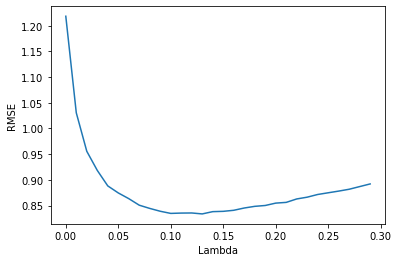

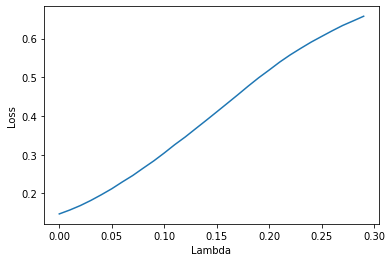

In [19]:
plt.plot(np.arange(0, 0.30, 0.01), rmses)
plt.xlabel('Lambda')
plt.ylabel('RMSE')
plt.show()
plt.plot(np.arange(0, 0.30, 0.01), losses)
plt.xlabel('Lambda')
plt.ylabel('Loss')
plt.show()

We see that the loss is the lowest for lambdas around 0.1.

### Weight decay test

In [20]:
rmses = np.zeros(30)
losses = np.zeros(30)
for i, decay in enumerate(np.arange(0, 0.003, 0.0001)):
    %time rmses[i], losses[i] = SGD_convinent(Z, Z_full, T_big, r=15, alpha=0.05, alpha_decay=0.95, multiply_alpha_after_epochs=10, momentum=0.0, decay=decay, l=0.1, num_epoch=200, init_mean=0, init_scale=0.01,)

CPU times: user 25.5 s, sys: 297 ms, total: 25.8 s
Wall time: 25.6 s
CPU times: user 24.7 s, sys: 254 ms, total: 25 s
Wall time: 24.8 s
CPU times: user 24.9 s, sys: 281 ms, total: 25.2 s
Wall time: 25 s
CPU times: user 24.4 s, sys: 272 ms, total: 24.7 s
Wall time: 24.5 s
CPU times: user 24.4 s, sys: 261 ms, total: 24.7 s
Wall time: 24.5 s
CPU times: user 24.7 s, sys: 270 ms, total: 25 s
Wall time: 24.7 s
CPU times: user 24.6 s, sys: 246 ms, total: 24.8 s
Wall time: 24.6 s
CPU times: user 24.4 s, sys: 233 ms, total: 24.7 s
Wall time: 24.5 s
CPU times: user 24.4 s, sys: 269 ms, total: 24.7 s
Wall time: 24.5 s
CPU times: user 24.5 s, sys: 284 ms, total: 24.8 s
Wall time: 24.6 s
CPU times: user 24.4 s, sys: 266 ms, total: 24.6 s
Wall time: 24.4 s
CPU times: user 24.4 s, sys: 258 ms, total: 24.7 s
Wall time: 24.4 s
CPU times: user 24.6 s, sys: 253 ms, total: 24.9 s
Wall time: 24.7 s
CPU times: user 24.4 s, sys: 276 ms, total: 24.7 s
Wall time: 24.5 s
CPU times: user 24.7 s, sys: 274 ms, tot

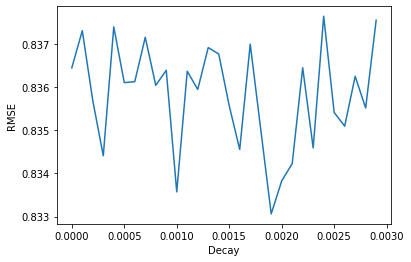

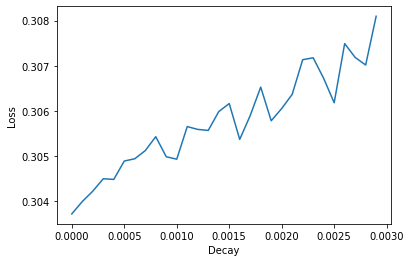

In [21]:
plt.plot(np.arange(0, 0.003, 0.0001), rmses)
plt.xlabel('Decay')
plt.ylabel('RMSE')
plt.show()
plt.plot(np.arange(0, 0.003, 0.0001), losses)
plt.xlabel('Decay')
plt.ylabel('Loss')
plt.show()

There is no sense to add weight decay to the model, since it doesn't improve RMSE. Furthermore loss it the lowest for no weight decay.

### Testing starting learning rate aka: $\alpha$.

In [22]:
rmses = np.zeros(19)
losses = np.zeros(19)
for i, a in enumerate(np.arange(0.005, 0.1, 0.005)):
    %time rmses[i], losses[i] = SGD_convinent(Z, Z_full, T_big, r=15, alpha=a, alpha_decay=0.95, multiply_alpha_after_epochs=10, momentum=0.0, decay=0, l=0.1, num_epoch=200, init_mean=0, init_scale=0.01,)

CPU times: user 24.5 s, sys: 234 ms, total: 24.8 s
Wall time: 24.6 s
CPU times: user 24.6 s, sys: 266 ms, total: 24.9 s
Wall time: 24.7 s
CPU times: user 24.3 s, sys: 278 ms, total: 24.6 s
Wall time: 24.4 s
CPU times: user 24.3 s, sys: 259 ms, total: 24.6 s
Wall time: 24.4 s
CPU times: user 24.2 s, sys: 255 ms, total: 24.4 s
Wall time: 24.2 s
CPU times: user 24.3 s, sys: 265 ms, total: 24.6 s
Wall time: 24.4 s
CPU times: user 24.3 s, sys: 264 ms, total: 24.5 s
Wall time: 24.3 s
CPU times: user 24.6 s, sys: 242 ms, total: 24.8 s
Wall time: 24.6 s
CPU times: user 24.2 s, sys: 266 ms, total: 24.5 s
Wall time: 24.3 s
CPU times: user 24.4 s, sys: 266 ms, total: 24.7 s
Wall time: 24.4 s
CPU times: user 24.4 s, sys: 270 ms, total: 24.7 s
Wall time: 24.4 s
CPU times: user 24.3 s, sys: 256 ms, total: 24.6 s
Wall time: 24.4 s
CPU times: user 24.4 s, sys: 256 ms, total: 24.6 s
Wall time: 24.4 s
CPU times: user 24.2 s, sys: 279 ms, total: 24.5 s
Wall time: 24.3 s
CPU times: user 24.7 s, sys: 238 m

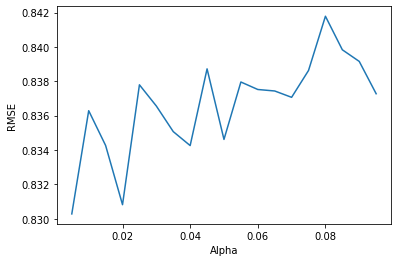

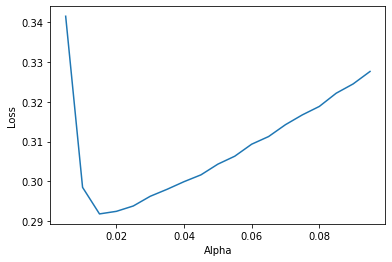

In [23]:
plt.plot(np.arange(0.005, 0.1, 0.005), rmses)
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.show()
plt.plot(np.arange(0.005, 0.1, 0.005), losses)
plt.xlabel('Alpha')
plt.ylabel('Loss')
plt.show()

Well, based on RMSE small $\alpha$ seems the best. If we look at loss, it looks like $\alpha = 0.02$ would make it, but we don't care about loss very much. 

### Testing momentum hyperparameter

In [15]:
rmses = np.zeros(20)
losses = np.zeros(20)
for i, m in enumerate(np.arange(0, 0.2, 0.01)):
    %time rmses[i], losses[i] = SGD_convinent(Z, Z_full, T_big, r=15, alpha=0.01, alpha_decay=0.95, multiply_alpha_after_epochs=10, momentum=m, decay=0, l=0.1, num_epoch=200, init_mean=0, init_scale=0.01,)

CPU times: user 27 s, sys: 272 ms, total: 27.3 s
Wall time: 27.2 s
CPU times: user 24.4 s, sys: 266 ms, total: 24.6 s
Wall time: 24.4 s
CPU times: user 24.4 s, sys: 256 ms, total: 24.6 s
Wall time: 24.4 s
CPU times: user 24.3 s, sys: 262 ms, total: 24.6 s
Wall time: 24.4 s
CPU times: user 24.5 s, sys: 278 ms, total: 24.7 s
Wall time: 24.5 s
CPU times: user 24.7 s, sys: 251 ms, total: 24.9 s
Wall time: 24.7 s
CPU times: user 24.4 s, sys: 248 ms, total: 24.7 s
Wall time: 24.5 s
CPU times: user 24.5 s, sys: 270 ms, total: 24.8 s
Wall time: 24.6 s
CPU times: user 24.6 s, sys: 253 ms, total: 24.8 s
Wall time: 24.6 s
CPU times: user 24.4 s, sys: 274 ms, total: 24.6 s
Wall time: 24.4 s
CPU times: user 24.7 s, sys: 264 ms, total: 25 s
Wall time: 24.8 s
CPU times: user 24.5 s, sys: 261 ms, total: 24.7 s
Wall time: 24.5 s
CPU times: user 24.7 s, sys: 247 ms, total: 25 s
Wall time: 24.8 s
CPU times: user 24.9 s, sys: 252 ms, total: 25.1 s
Wall time: 24.9 s
CPU times: user 24.7 s, sys: 263 ms, tot

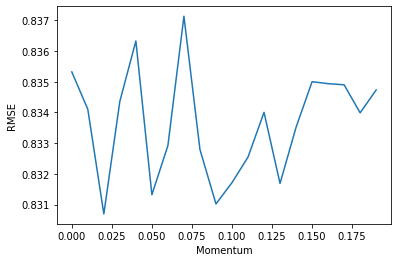

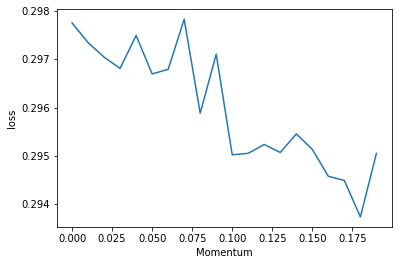

In [17]:
plt.plot(np.arange(0, 0.2, 0.01), rmses)
plt.xlabel('Momentum')
plt.ylabel('RMSE')
plt.show()
plt.plot(np.arange(0, 0.2, 0.01), losses)
plt.xlabel('Momentum')
plt.ylabel('loss')
plt.show()